In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [5]:
# calculation RMSE
def compute_rmse(R, R_hat, index):
    X = np.multiply((R - R_hat), index)
    Y = np.sum(np.multiply(X, X))
    Z = np.sum(index)
    return np.sqrt(Y / Z)

# calculation HR@n
def compute_hr_at_n(R, R_hat, R_exclude, n=10):
    hr_total = 0
    num_users = R.shape[0]
    for u in range(num_users):
        if np.sum(R_exclude[u]) >= n:
            continue
        top_n_indices = np.argsort(-R_hat[u])[:n]
        consumed_indices = np.where(R[u] > 0)[0]
        consumed_in_top_n = np.intersect1d(consumed_indices, top_n_indices)
        hr_total += len(consumed_in_top_n) / n
    hr_total /= num_users
    return hr_total

In [10]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
users_num = 943 + 1
movies_num = 1682 + 1

param_grid = {  
    'mf_dim':[16,32],
    'mlp_layer_sizes':[[32,16],[64,32]],
    'dropout':[0.5, 1.0],
    'learning_rate':[0.01, 0.1]
}
best_hr_10 = float('inf')
best_params = {}

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets
train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)

epochs = 0

for params in ParameterGrid(param_grid):
    hr_n10_folds = []
    model = NeuMF(users_num,movies_num, params['mf_dim'], params['mlp_layer_sizes'], params['dropout'])
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    test_loss = []
    train_loss = []  

    for epoch in range(2):
        model.train()
        tr_loss=[]
        print("Training "+str(epochs))
        epochs += 1
        for (u,i,l) in tqdm.tqdm(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(u,i,sigmoid=True)
            l = l.unsqueeze(1)
            # calculate loss
            loss = criterion(yhat, l)
            tr_loss.append(loss.detach().numpy())
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        train_loss.append(np.mean(tr_loss))
        model.eval()
        predictions = []
        ground_truth = []
        with torch.no_grad():
            t_loss=[]
            for i, (u,i,l) in enumerate(test_dl):
                yhat = model(u, i, sigmoid=True)
                predictions.append(yhat)
                ground_truth.append(l.unsqueeze(1).numpy())
                l = l.unsqueeze(1)
                tl = criterion(yhat, l)
                t_loss.append(tl)
                
            test_loss.append(np.mean(t_loss))
        
        R_hat = np.vstack(predictions)
        R = np.vstack(ground_truth)
        R_exclude = np.zeros_like(R)

        rmse = compute_rmse(R, R_hat, np.logical_not(R_exclude))
        hr_at_10 = compute_hr_at_n(R, R_hat, R_exclude, n=10)

        hr_n10_folds.append(hr_at_10)

        print("RMSE:", rmse)
        print("HR@10:", hr_at_10)

    avg_hr_10 = np.mean(hr_n10_folds)

    print('\nAverage hr@10 in this combination paramater :', avg_hr_10)

    if avg_hr_10 < best_hr_10:
        best_hr_10 = avg_hr_10
        best_params = params

print("Best hyperparameters:", best_params)

Training 0


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


RMSE: 0.49579448814923976
HR@10: 0.03333333333332127
Training 1


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


RMSE: 0.4835313048670772
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 2


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


RMSE: 0.48867301783439504
HR@10: 0.03333333333332127
Training 3


100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


RMSE: 0.47178700200452395
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 4


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


RMSE: 0.49181983622265923
HR@10: 0.03333333333332127
Training 5


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


RMSE: 0.4847454900297337
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 6


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


RMSE: 0.48124374319525787
HR@10: 0.03333333333332127
Training 7


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


RMSE: 0.468559353591988
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 8


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


RMSE: 0.4955833085922168
HR@10: 0.03333333333332127
Training 9


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


RMSE: 0.4828600131691465
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 10


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


RMSE: 0.490419609344046
HR@10: 0.03333333333332127
Training 11


100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


RMSE: 0.475657234453025
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 12


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


RMSE: 0.49979323524312697
HR@10: 0.03333333333332127
Training 13


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


RMSE: 0.49534516190943395
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 14


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


RMSE: 0.4877700574105077
HR@10: 0.03333333333332127
Training 15


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


RMSE: 0.4766404137128691
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 16


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


RMSE: 0.4952240161501409
HR@10: 0.03333333333332127
Training 17


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


RMSE: 0.49407704424618
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 18


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


RMSE: 0.5104476340520887
HR@10: 0.03333333333332127
Training 19


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


RMSE: 0.5090108296879187
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 20


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


RMSE: 0.4932707490831396
HR@10: 0.03333333333332127
Training 21


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


RMSE: 0.4921693945082577
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 22


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


RMSE: 0.4909049261154088
HR@10: 0.03333333333332127
Training 23


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


RMSE: 0.4898537595335639
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 24


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


RMSE: 0.5104252178280299
HR@10: 0.03333333333332127
Training 25


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


RMSE: 0.508998326986445
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 26


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


RMSE: 0.4899740406867235
HR@10: 0.03333333333332127
Training 27


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


RMSE: 0.48897033876044055
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 28


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


RMSE: 0.5095822846388092
HR@10: 0.03333333333332127
Training 29


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


RMSE: 0.508148670779117
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Training 30


100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


RMSE: 0.49845699413289407
HR@10: 0.03333333333332127
Training 31


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


RMSE: 0.4972353253239355
HR@10: 0.03333333333332127

Average hr@10 in this combination paramater : 0.03333333333332127
Best hyperparameters: {'dropout': 0.5, 'learning_rate': 0.01, 'mf_dim': 16, 'mlp_layer_sizes': [32, 16]}


### Plot results

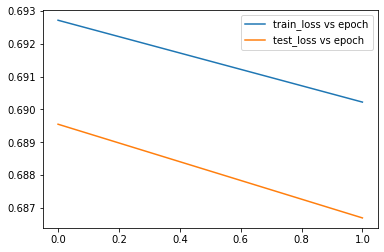

In [12]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()